# Практическая работа №1
## Тема: Предварительная обработка данных
## Выполнил: Шинкаренко Даниил Дмитриевич
## Группа: КИ21-16/1б
## Вариант: 24

## Цель работы
### Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.

## Задачи
### Выполнение практической работы предполагает решение следующий задач:

### 1. Визуальный анализ исходных данных
### 2. Поиск аномальных значений
### 3. Поиск и восстановление отсутствующих значений
### 4. Преобразование данных

## Ход работы
### Импортируем необходимые библиотеки

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.impute
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
import pandas as pd
import seaborn as sns
import sklearn.impute
from scipy.stats import sigmaclip

from functions import draw_charts, draw_histogram, remove_outliers, quartile_method

data = pd.read_excel('dataframe.xlsx')
PRODUCT_TYPE = "cat13_productType"
TEMPERATURE = "cat14_temprature"
NUM1 = "num1_25"
NUM2 = "num2_25"
NUM3 = "num3_25"
headers = [PRODUCT_TYPE, TEMPERATURE, NUM1, NUM2, NUM3]
dataframe = pd.DataFrame(data[headers])
dataframe

,cat13_productType,cat14_temprature,num1_25,num2_25,num3_25
0,Wood,Very Hot,916.153076,294.981999,703.129209
1,Plastic,cold,531.175435,85.120795,614.411678
2,-,Very Hot,1214.908273,375.522597,530.122551
3,Plastic,Very Hot,-460.238016,652.067484,620.665623
4,metal,cold,-9999.000000,283.214616,558.01966
...,...,...,...,...,...
995,Wood,Very Hot,1551.439719,122.751805,701.794422
996,Wood,cold,-907.872075,247.809685,578.433583
997,Metal,Very Hot,36.495280,281.114939,615.993257
998,Wood,-,-14.590580,33.625780,-


## 1. Визуальный анализ данных
### Для каждого признака в исходном наборе данных были созданы графики, которые помогают визуально представить данные. Все функции, используемые для построения этих графиков, были вынесены в отдельный файл functions.py.

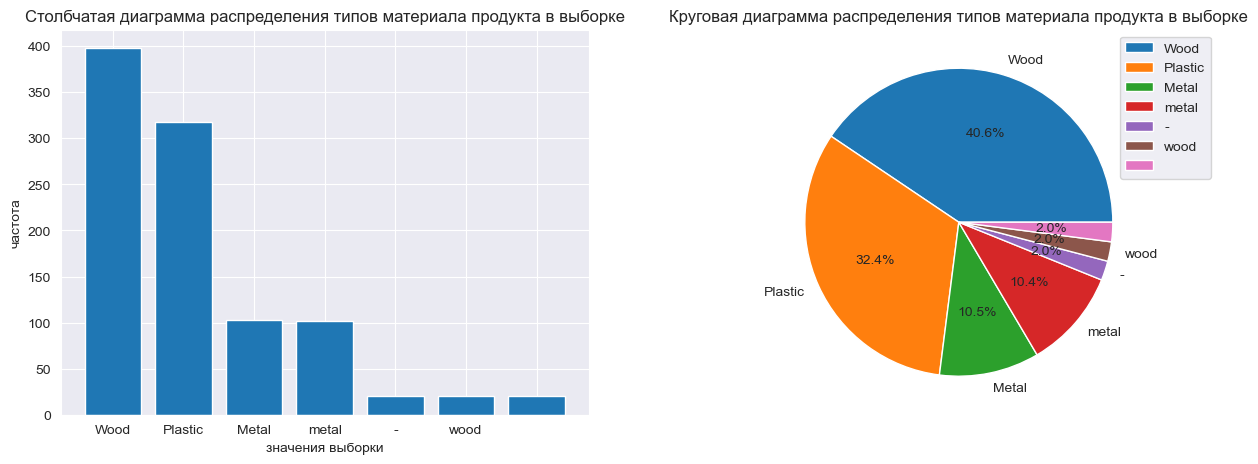

In [33]:
draw_charts(dataframe, PRODUCT_TYPE, "типов материала продукта")

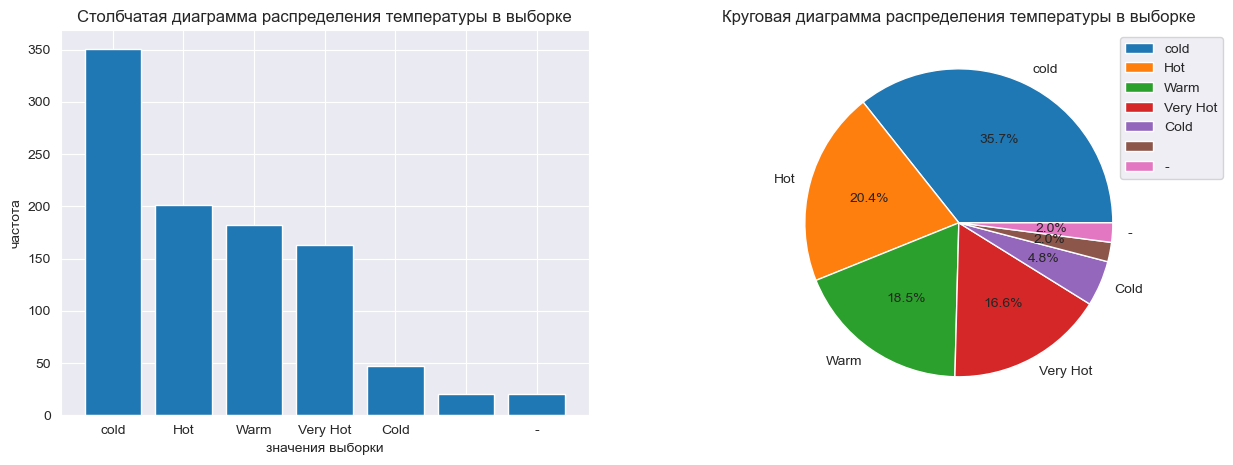

In [34]:
draw_charts(dataframe, TEMPERATURE, "температуры")

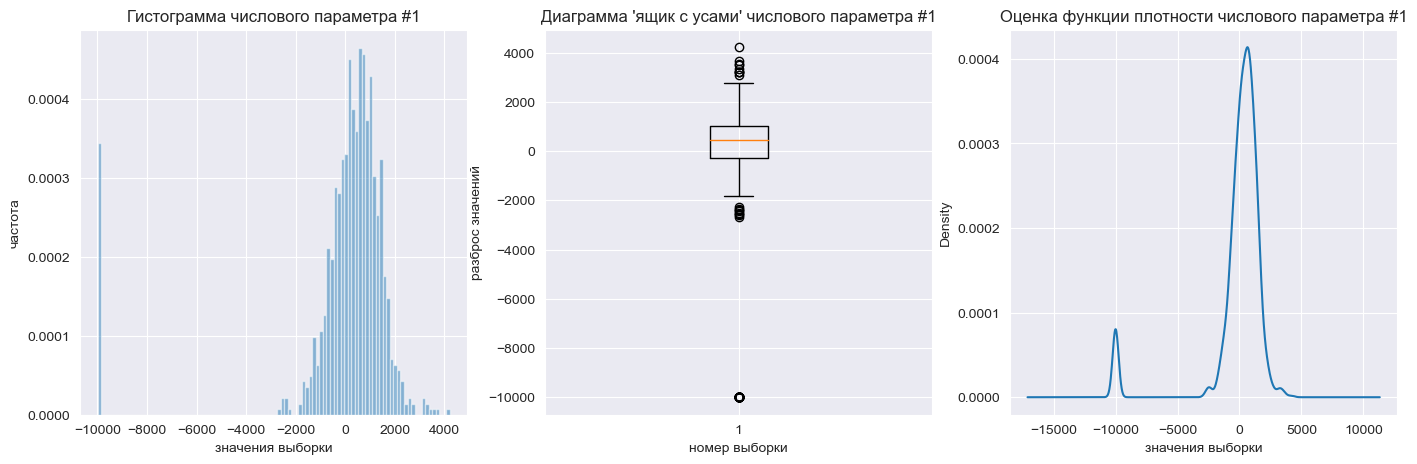

In [35]:
draw_histogram(dataframe, NUM1, 1)

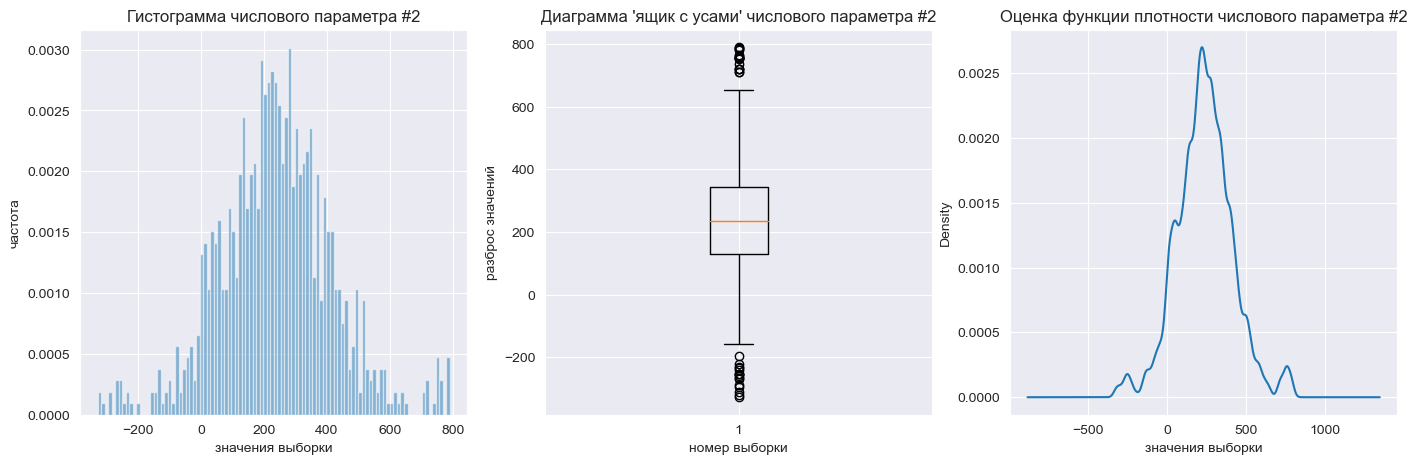

In [36]:
draw_histogram(dataframe, NUM2, 2)

График не может быть построен, так как столбец num3_25 содержит не только числовые значения.


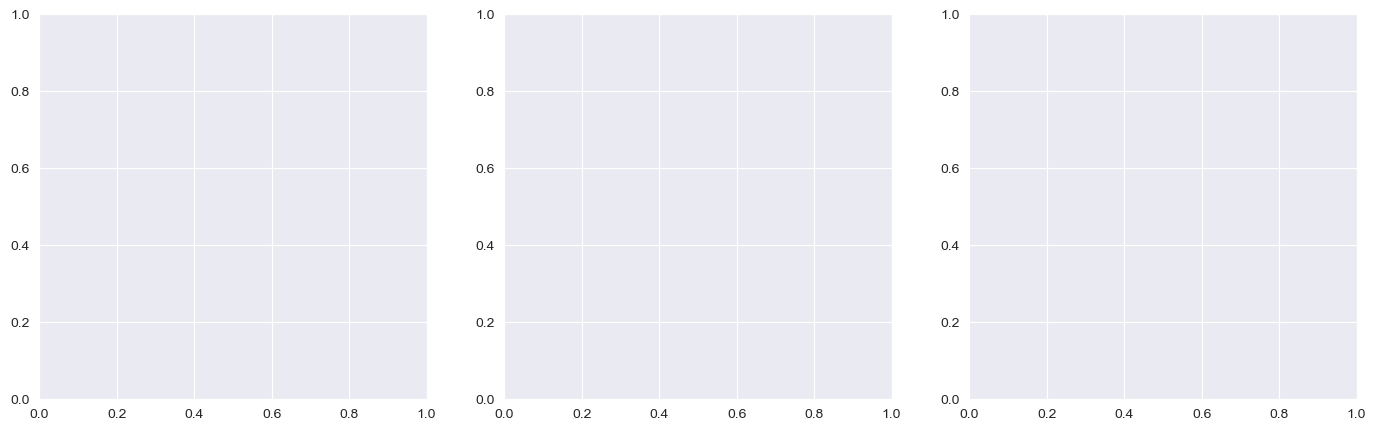

In [37]:
try:
    draw_histogram(dataframe, NUM3, 3)
except TypeError:
    print("График не может быть построен, так как столбец {} содержит не только числовые значения.".format(NUM3))

## 2. Проверка правдоподобности исходных данных
### После анализа графиков можно заключить, что в таблице присутствуют некорректные значения, такие как пропущенные значения. Используя метод info, можно заметить, что некоторые столбцы имеют неверный тип данных.

In [38]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cat13_productType  981 non-null    object 
 1   cat14_temprature   984 non-null    object 
 2   num1_25            1000 non-null   float64
 3   num2_25            951 non-null    float64
 4   num3_25            973 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


## Изменение качественных признаков
### Для понимания процесса очистки данных выводим уникальные значения, содержащиеся в каждом столбце.

In [39]:
dataframe.cat13_productType.unique()

array(['Wood', 'Plastic', '-', 'metal', 'Metal', nan, 'wood', ' '],
      dtype=object)

In [40]:
dataframe.cat14_temprature.unique()

array(['Very Hot', 'cold', 'Hot', 'Cold', 'Warm', nan, ' ', '-'],
      dtype=object)

### Выполним преобразование найденных значений в требуемый формат: все пустые значения заменим на None, а признаки, отличающиеся по формату написания, приведем к единому стилю.

In [41]:
mapping_prod = {" ": None, "-": None, "": None, np.nan: None, "wood": "Wood", "metal": "Metal"}
mapping_temp = {" ": None, "-": None, "": None, np.nan: None, "cold": "Cold"}

dataframe[PRODUCT_TYPE].replace(mapping_prod, inplace=True)
dataframe[TEMPERATURE].replace(mapping_temp, inplace=True)

### Колонки 1 и 2 были преобразованы к категориальному(category) типу.

In [42]:
dataframe[PRODUCT_TYPE] = dataframe[PRODUCT_TYPE].astype("category")
dataframe[TEMPERATURE] = dataframe[TEMPERATURE].astype("category")

### Изменение количественных признаков

In [43]:
dataframe.num3_25.apply(lambda x: x if not isinstance(x, float) else None).unique()

array([None, ' ', '-'], dtype=object)

In [44]:
dataframe[NUM3].replace(to_replace=[" ", "-", "", None], value=np.nan, inplace=True)

### Построим ряд графиков исходя из обновленных значений последнего столбца.

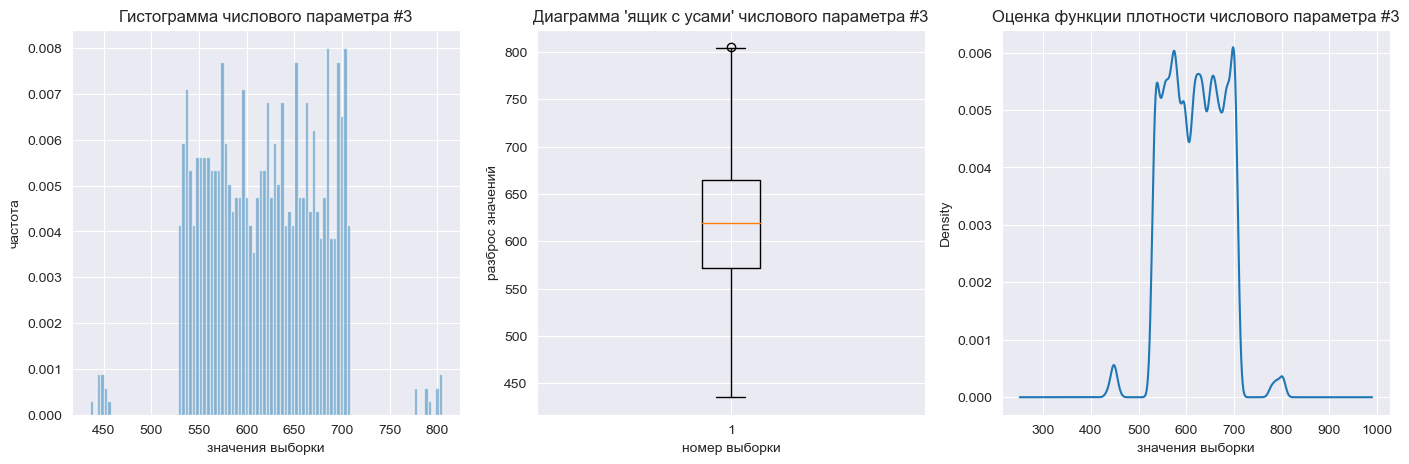

In [45]:
draw_histogram(dataframe, NUM3, 3)

In [46]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   cat13_productType  941 non-null    category
 1   cat14_temprature   944 non-null    category
 2   num1_25            1000 non-null   float64 
 3   num2_25            951 non-null    float64 
 4   num3_25            913 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 25.8 KB


## 3. Поиск аномальных значений
### Для возможности сравнения двух методов была создана копия датафрейма.

In [47]:
dataframe_copy = dataframe_sigma = dataframe_quantile = dataframe.copy()

## Метод сигм
### Были обнаружены выбросы в первом числовом параметре, которые значительно отличаются от остальных значений. Для удаления строк, содержащих выбросы, был использован соответствующий метод датафрейма.

In [48]:
columns_to_check = [NUM1, NUM2, NUM3]
for column in columns_to_check:
    dataframe_sigma = remove_outliers(dataframe_sigma, column)

C:\Users\dahhw\anaconda3\envs\analysis1\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dahhw\anaconda3\envs\analysis1\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\dahhw\anaconda3\envs\analysis1\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dahhw\anaconda3\envs\analysis1\lib\site-packages\scipy\stats\_stats_py.py:3450: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
C:\Users\dahhw\anaconda3\envs\analysis1\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
dataframe_sigma.count()

cat13_productType    880
cat14_temprature     884
num1_25              934
num2_25              886
num3_25              850
dtype: int64

In [50]:
## Метод квантилей

In [51]:
for col in [NUM1, NUM2, NUM3]:
    low, high = quartile_method(dataframe_quantile, col)
    dropped_values = dataframe_quantile[col][(dataframe_quantile[col] < low) | (dataframe_quantile[col] > high)]
    dataframe_quantile = dataframe_quantile.drop(dropped_values.index)

dataframe_quantile_count = dataframe_quantile.count()
dataframe_quantile_count

cat13_productType    847
cat14_temprature     852
num1_25              899
num2_25              851
num3_25              818
dtype: int64

### Было удалено 118 выбросов из датафрейма с помощью метода сигм. 107 выбросов были удалены с помощью метода квантилей. Используем результаты очистки данных, полученных с помощью метода сигм.

In [52]:
dataframe = dataframe_sigma

## 4. Поиск и восстановление пропущенных значений
### Пропущенные значения второго признака были заполнены наиболее часто встречающимся значением.

In [53]:
print(dataframe[TEMPERATURE].value_counts())

Cold        370
Hot         189
Warm        173
Very Hot    152
Name: cat14_temprature, dtype: int64


In [54]:
dataframe[TEMPERATURE] = dataframe[TEMPERATURE].fillna("Cold")

### Значения, которые отсутствовали в четвёртом признаке, были заполнены медианным значением.

In [55]:
dataframe[NUM2].fillna(dataframe[NUM2].median(), inplace=True)

### Значения, отсутствующие в пятом признаке, были заполнены с использованием метода "k-ближайших соседей".

In [56]:
# Сохраняем выходные данные fit_transform() непосредственно в целевом столбце NUM3.
knn_inputter = sklearn.impute.KNNImputer()
dataframe[NUM3] = knn_inputter.fit_transform(dataframe[[NUM1, NUM2, NUM3]])[:, 2]
num_non_null = dataframe[NUM3].count()
print(f"Количество не нулевых элементов в NUM3: {num_non_null}")

Количество не нулевых элементов в NUM3: 934


## 5. Преобразование данных
## Кодировка категориальных признаков
### Первый категориальный признак был закодирован с помощью One-Hot Encoding.

In [57]:
enc_df = pd.get_dummies(dataframe[PRODUCT_TYPE])
dataframe = pd.concat([dataframe, enc_df], axis=1)
dataframe

,cat13_productType,cat14_temprature,num1_25,num2_25,num3_25,Metal,Plastic,Wood
0,Wood,Very Hot,916.153076,294.981999,703.129209,0,0,1
1,Plastic,Cold,531.175435,85.120795,614.411678,0,1,0
2,NaN,Very Hot,1214.908273,375.522597,530.122551,0,0,0
3,Plastic,Very Hot,-460.238016,652.067484,620.665623,0,1,0
5,Metal,Very Hot,501.734272,223.020395,635.070564,1,0,0
...,...,...,...,...,...,...,...,...
995,Wood,Very Hot,1551.439719,122.751805,701.794422,0,0,1
996,Wood,Cold,-907.872075,247.809685,578.433583,0,0,1
997,Metal,Very Hot,36.495280,281.114939,615.993257,1,0,0
998,Wood,Cold,-14.590580,33.625780,600.805084,0,0,1


### Закодируем второй категориальный признак с помощью Label Encoding.

In [62]:
le = LabelEncoder()
dataframe[TEMPERATURE] = le.fit_transform(dataframe[TEMPERATURE])
dataframe[TEMPERATURE].value_counts()

0    420
1    189
3    173
2    152
Name: cat14_temprature, dtype: int64

## Преобразование количественных признаков
### Первый и второй количественный признакы были нормализованы, то есть их значения были приведены к диапазону от 0 до 1. В то же время, стандартизированный набор данных имеет нулевое среднее значение и единичную дисперсию (стандартное отклонение).

In [ ]:
min_max_scaler = MinMaxScaler()
scaled_values = min_max_scaler.fit_transform(dataframe[[NUM1, NUM2]])
dataframe[["num1_scaled", "num2_scaled"]] = scaled_values

### Третий количественный признак был приведён к стандартизированному виду.

In [63]:
scaler = StandardScaler()
num_cols = [NUM1, NUM2, NUM3]
dataframe[[f"{col}_scaled" for col in num_cols]] = scaler.fit_transform(dataframe[num_cols])
dataframe.head(6)

,cat13_productType,cat14_temprature,num1_25,num2_25,num3_25,Metal,Plastic,Wood,num1_25_scaled,num2_25_scaled,num3_25_scaled
0,Wood,2,916.153076,294.981999,703.129209,0,0,1,0.562290,0.338410,1.490285
1,Plastic,0,531.175435,85.120795,614.411678,0,1,0,0.105624,-0.862812,-0.072909
2,NaN,2,1214.908273,375.522597,530.122551,0,0,0,0.916677,0.799415,-1.558075
3,Plastic,2,-460.238016,652.067484,620.665623,0,1,0,-1.070403,2.382326,0.037285
5,Metal,2,501.734272,223.020395,635.070564,1,0,0,0.070701,-0.073490,0.291099
6,Plastic,2,1260.678849,229.011316,683.561798,0,1,0,0.970971,-0.039199,1.145509
